In [1]:
import matplotlib.pyplot as plt
import torch
from dataset import ADNIDataModule

from pretraining.maskedAutoencoder import LitMaskedAutoencoder
from defaults import DEFAULTS, MODEL_DEFAULTS
from pretraining.pretraining_utils import interpolate_pos_embed

/dhc/home/oliver.zimmermann/conda3/envs/mml_env/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/dhc/home/oliver.zimmermann/conda3/envs/mml_env/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to use

In [2]:
#model_path = "/dhc/groups/adni_transformer/checkpoints/dev-MaskedAutoencoder/MaskedAutoencoder/2023-08-16 08:37:33.ckpt"
model_path = "/dhc/groups/adni_transformer/checkpoints/pretrainMaskedAutoencoder/MaskedAutoencoder/2023-08-16 15:52:14-epoch=35-val_loss=0.00-train_loss=0.0300.ckpt"
better_model_path = "/dhc/groups/adni_transformer/checkpoints/pretrainMaskedAutoencoder/MaskedAutoencoder/2023-08-17 09:30:11-epoch=04-val_loss=0.00-train_loss=0.0110.ckpt"

In [3]:
dataset="PretrainADNI"
batch_size=1 #=DEFAULTS["HYPERPARAMETERS"]["batch_size"]
num_workers=DEFAULTS["DATALOADING"]["num_workers"]
data_dir=DEFAULTS["DATALOADING"]["data_dir"]
meta_file_path=DEFAULTS["DATALOADING"]["meta_file_path"]
train_fraction=DEFAULTS["HYPERPARAMETERS"]["train_fraction"]
validation_fraction=DEFAULTS["HYPERPARAMETERS"]["validation_fraction"]
test_fraction=DEFAULTS["HYPERPARAMETERS"]["test_fraction"]

print(f"dataset: {dataset}")
print(f"batch_size: {batch_size}")
print(f"num_workers: {num_workers}")
print(f"data_dir: {data_dir}")
print(f"meta_file_path: {meta_file_path}")
print(f"train_fraction: {train_fraction}")
print(f"validation_fraction: {validation_fraction}")
print(f"test_fraction: {test_fraction}")

dataset: PretrainADNI
batch_size: 1
num_workers: 4
data_dir: /dhc/groups/adni_transformer/adni_128_int/
meta_file_path: /dhc/groups/adni_transformer/adni_metadata/df_procAlex_MMSE.csv
train_fraction: 0.8
validation_fraction: 0.0
test_fraction: 0.0


In [4]:
data = ADNIDataModule(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        data_dir=data_dir,
        meta_file_path=meta_file_path,
        train_fraction=train_fraction,
        validation_fraction=validation_fraction,
        test_fraction=test_fraction,
    )

data.setup(stage="fit")
train_loader = data.train_dataloader()


(0, 2)
(10369, 2)
(97347, 2)
(0, 2)
(0, 2)
(0, 2)
(0, 2)
(2416, 2)
(2416, 2)


In [10]:
example_batch = next(iter(train_loader))
print(f"Input batch shape: {example_batch.shape}")

Input batch shape: torch.Size([1, 1, 16, 128, 128])


In [6]:
model = LitMaskedAutoencoder.load_from_checkpoint(model_path)
better_model = LitMaskedAutoencoder.load_from_checkpoint(better_model_path)

In [ ]:
model_args = MODEL_DEFAULTS["MaskedAutoencoder"]
model_args["num_frames"] = 128
model_args["learning_rate"] = 5e-2

In [ ]:
model = LitMaskedAutoencoder(**model_args).autoencoder
state_dict = model.state_dict()

In [ ]:
checkpoint_model = LitMaskedAutoencoder.load_from_checkpoint(model_path)

In [ ]:
checkpoint = torch.load(model_path, map_location='cpu')
if "model" in checkpoint.keys():
    checkpoint_model = checkpoint["model"]
else:
    checkpoint_model = checkpoint["model_state"]

In [ ]:
for k in ["head.weight", "head.bias"]:
            if (
                k in checkpoint_model
                and checkpoint_model[k].shape != state_dict[k].shape
            ):
                print(f"Removing key {k} from pretrained checkpoint")
                del checkpoint_model[k]

In [ ]:
interpolate_pos_embed(model, checkpoint_model)
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)
trunc_normal_(model.head.weight, std=2e-5)

In [11]:
loss, pred, mask = model(example_batch, mask_ratio=0.9)
predictions = model.autoencoder.unpatchify(pred)
loss, pred, mask = better_model(example_batch, mask_ratio=0.9)
better_predictions = better_model.autoencoder.unpatchify(pred)

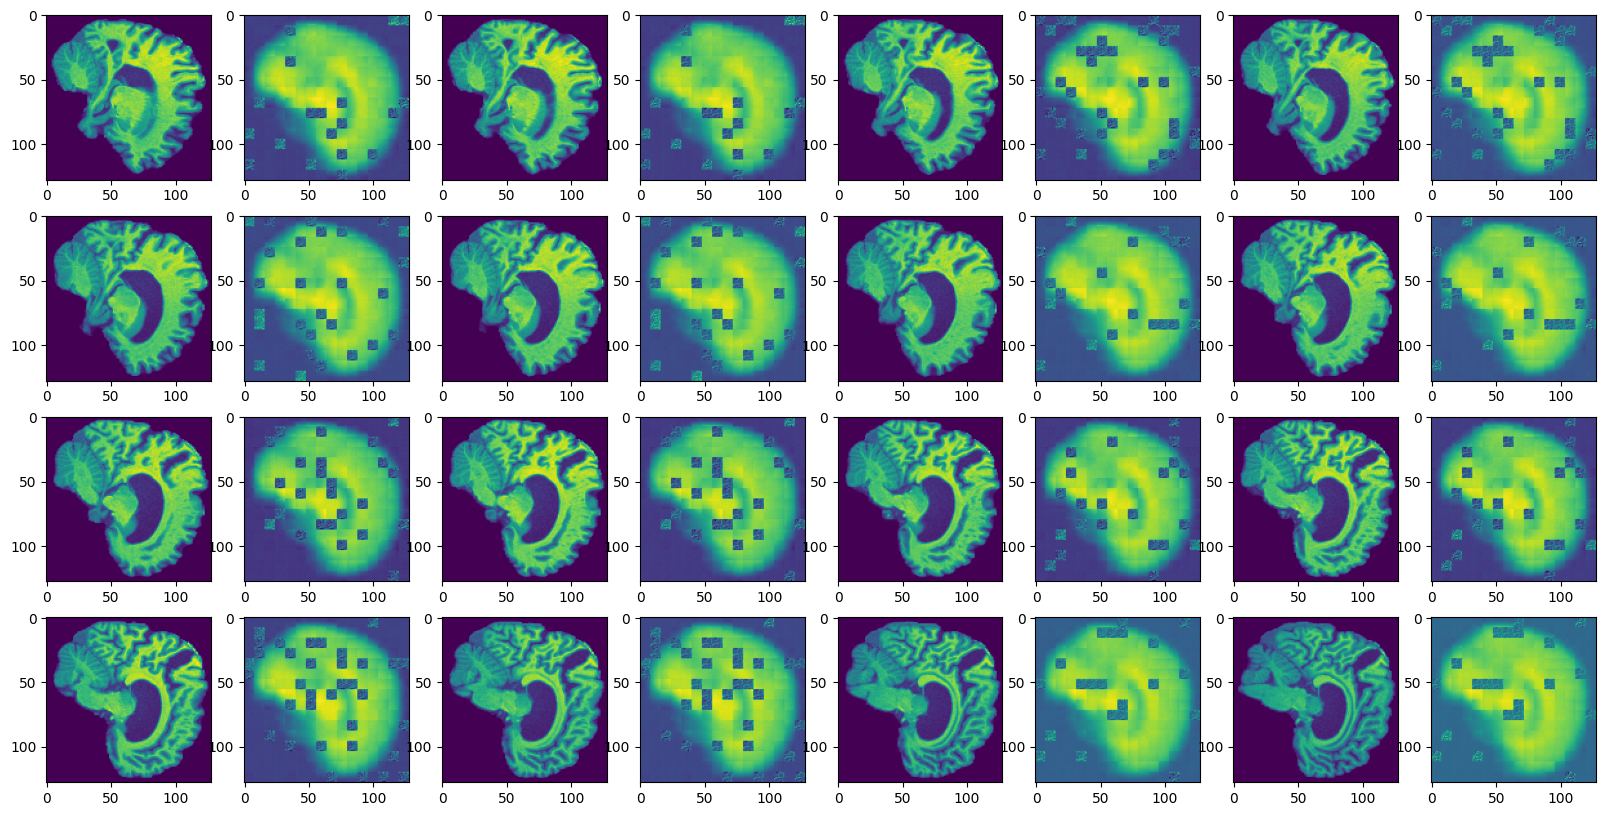

In [12]:
fig = plt.figure(figsize=(20, 10))
images_num = example_batch.shape[2]
samples_num = 16
columns = 8
rows = samples_num * 2 // columns
for i in range(0, samples_num):
    original = example_batch[0, 0, (images_num//samples_num)*i, :, :]
    fig.add_subplot(rows, columns, (2*i)+1)
    plt.imshow(original)
    prediction = better_predictions[0, 0, (images_num//samples_num)*i, :, :]
    fig.add_subplot(rows, columns, (2*i)+2)
    plt.imshow(prediction.detach().numpy())
plt.show()

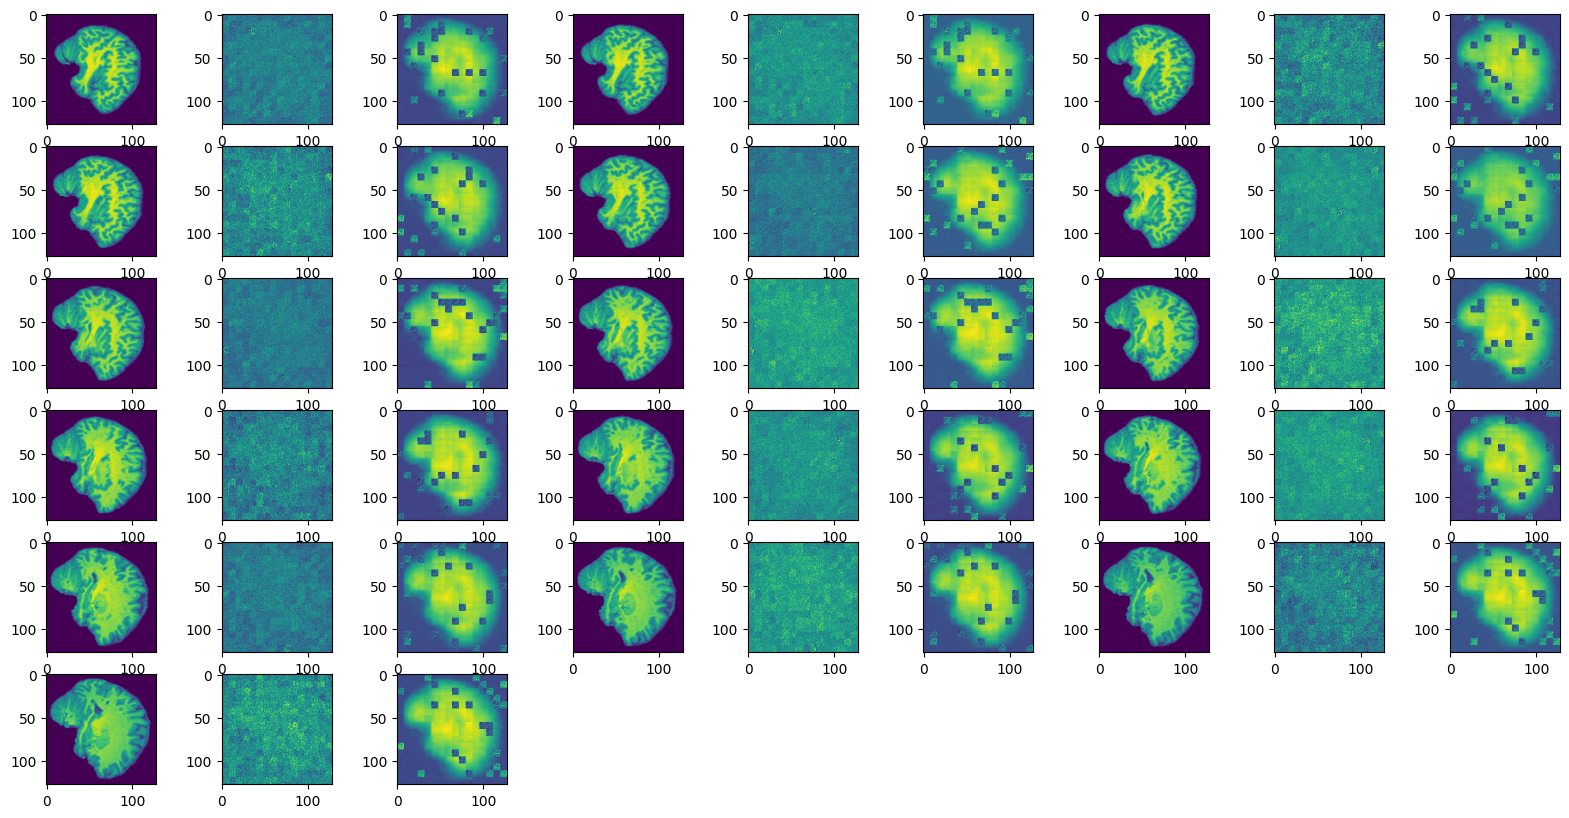

In [8]:
fig = plt.figure(figsize=(20, 10))
images_num = example_batch.shape[2]
samples_num = 16
columns = 9
rows = samples_num *3 // columns + 1
for i in range(0, samples_num):
    original = example_batch[0, 0, (images_num//samples_num)*i, :, :]
    fig.add_subplot(rows, columns, (3*i)+1)
    plt.imshow(original)
    prediction = predictions[0, 0, (images_num//samples_num)*i, :, :]
    fig.add_subplot(rows, columns, (3*i)+2)
    plt.imshow(prediction.detach().numpy())
    better_prediction = better_predictions[0, 0, (images_num//samples_num)*i, :, :]
    fig.add_subplot(rows, columns, (3*i)+3)
    plt.imshow(better_prediction.detach().numpy())
plt.show()

In [ ]:
masks = mask.reshape(1, 32, 8, 8)

In [ ]:
fig = plt.figure(figsize=(10, 5))
columns = 8
rows = 2
for i in range(0, columns*rows):
    img = masks[0, i, :, :]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img.detach().numpy())
plt.show()